In [15]:
import numpy as np
from tqdm import tqdm

In [16]:
import yfinance as yf
# List of yfinance-compatible tickers
tickers = [
    "^GSPC",    # S&P 500 Index
      # iShares U.S. Real Estate ETF (Morgan Stanley REIT Index)
]

# Download monthly returns data for the last 14 years
start_date = "2010-01-01"
end_date = "2024-01-01"

# Fetch monthly data for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1mo', progress=False)['Adj Close']
    returns = data.pct_change().dropna() * 100  # Calculate monthly returns


### Define Distribution Functions

In [17]:
def N(mean, variance, size = None):
    return np.random.normal(mean, np.sqrt(variance), size)

def U(start_point, end_point, size = None):
    return np.random.uniform(start_point, end_point, size)

def B(α, β, size = None):
    return np.random.beta(α, β, size)

### Define Observation Functions

In [18]:
def transition_function(x̄, ϕ_x, σ_x, ξ_t, x_t):
    particles = x̄ + ϕ_x * (x_t - x̄) + σ_x * ξ_t
    return particles

In [19]:
def observation_function(μ̄, x_t, ϵ_t):
    y_t = μ̄ + np.exp(x_t / 2) * ϵ_t
    return y_t

In [22]:
def observation_likelihood(y, μ̄, x):
    σ_t = np.exp(x / 2)

    likelihood = (1 / (np.sqrt(2 * np.pi) * σ_t)) * np.exp(- ((y - μ̄)**2) / (2 * σ_t**2))

    return likelihood

In [ ]:
observation = Y = returns.values
Y_train = Y[:48]

In [ ]:
L = 10_000 # number of particles
T = len(Y_train) # number of time steps

In [25]:
μ̄ = U(-5, 5, L) # shape (L, 1)
x̄ = U(-1, 5, L) # shape (L, 1)
ϕ_x = 2 * B(20, 1.5, L) - 1 # shape (L, 1)
σ_x = U(0, 2, L) # shape (L, 1)

In [ ]:
x = np.zeros((T + 1, L)) # latent x, shape (T + 1, L)
p = np.zeros((T, L)) # particles, shape (T, L)
α = np.zeros((T, L)) # weights, shape (T, L)
y = np.zeros((T, L)) # estimation of expected return, shape (T, L)

ξ = np.zeros((T, L)) # latent x noise, shape (T, L)
ϵ = np.zeros((T, L)) # observation noise, shape (T, L)

### initialize $x_0$

In [27]:
x[0] = N(x̄, (σ_x ** 2) / (1 - ϕ_x ** 2))

### Particle Filtering Loop

In [28]:
for t in tqdm(range(0, T, 1)):
    # generate system noise and calculate particles
    ξ[t] = N(0, 1, L)
    p[t] = transition_function(x̄, ϕ_x, σ_x, ξ[t], x[t])
    # particles = x̄ + ϕ_x * (x[t-1] - x̄) + σ_x * ξ_t


    # generate noise and calculate expected observations
    ϵ[t] = N(0, 1, L)
    y[t] = observation_function(μ̄, p[t], ϵ[t])


    # calculate likelihood with Gaussian likelihood
    α[t] = observation_likelihood(observation[t], μ̄, p[t])
    

    # calculate the weights as the normalized likelihoods
    weights = α[t]
    weights /= np.sum(α[t])

    # Resample latents from the particles
    for sample_j in range(L):
        sample_choice = np.random.choice(np.arange(L), p = weights)
        x[t + 1, sample_j] = p[t, sample_choice]


  3%|▎         | 5/167 [00:05<02:46,  1.03s/it]


KeyboardInterrupt: 

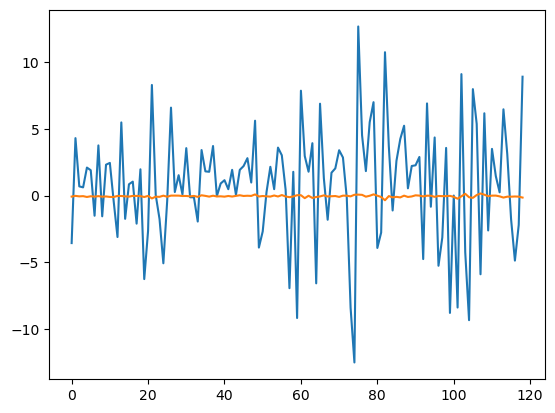

In [13]:
from matplotlib import pyplot as plt
plt.plot(Y[47:-1])
plt.plot(np.average(y, axis=1)[48:])